# Satellite Acquisition 
## (via the parallel frequency space search algorithm)
### (It still doesn't work)

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. This code implements the parallel code phase search algorithm, which is the most complex of those available, but is also the fastest since it returns a result in just one iteration. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.

As noted in the L-12 GPS data README, the sampling frequency is 4.092 MHz. and the IF is 0. Also note that the L1 signal hits the antenna at the 1.57542 GHz frequency (10.23 MHz x 154). This is dealt with by the hardware frontend, so we only have to concern ourselves with the 1.023 MHz BPSK modulated C/A code.

**Note: we should only perform this acquisition method on ~20ms sections of data, see book for details**

## Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import peakutils
import struct
import math
import scipy.stats as sp

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode

# Start of ByteToIQPairs Function
def ByteToIQPairs( TheByte ):
    IQPairs = []
    
    # This code reads each of the four pairs of bits from the byte 
    # and determines the sign and magnitude. Then it returns a list 
    # containing two pairs of IQ data as floating point [I1,Q1,I2,Q2].
    # For magnitude: a bit value of 1 means mag 1, 0 means mag 1/3
    # For sign: a bit value of 1 means negative, 0 means positive
    # This interpretation was taken by the sample code provided
    # in the PSAS Launch12 github repo (example was provided in C)
    #
    # f_s = 4.092 MHz (sampling rate of raw signal)
   
    IMag1 = (TheByte >> 7) & (0b00000001)
    ISign1 = (TheByte >> 6) & (0b00000001)
    I1 = 1.0 if (IMag1 == 1) else 1.0/3.0
    I1 = -I1 if (ISign1 == 1) else I1
    IQPairs.append(I1)
    
    QMag1 = (TheByte >> 5) & (0b00000001)
    QSign1 = (TheByte >> 4) & (0b00000001)
    Q1 = 1.0 if (QMag1 == 1) else 1.0/3.0
    Q1 = -Q1 if (QSign1 == 1) else Q1
    IQPairs.append(Q1)    
        
    IMag2 = (TheByte >> 3) & (0b00000001)
    ISign2 = (TheByte >> 2) & (0b00000001)
    I2 = 1.0 if (IMag2 == 1) else 1.0/3.0
    I2 = -I2 if (ISign2 == 1) else I2
    IQPairs.append(I2)    
        
    QMag2 = (TheByte >> 1) & (0b00000001)
    QSign2 = (TheByte >> 0) & (0b00000001)
    Q2 = 1.0 if (QMag2 == 1) else 1.0/3.0
    Q2 = -Q2 if (QSign2 == 1) else Q2
    IQPairs.append(Q2)
    
    return IQPairs 
# End of ByteToIQPairs Function


## Import data File

- Information on file "JGPS@-32.041913222" can be found at: https://github.com/psas/Launch-12/tree/gh-pages/data/GPS

In [2]:

print("Opening a file.")
fHandle = open('../resources/JGPS@-32.041913222','rb')
print("File handle is: %d." % (fHandle.fileno()))

# Read file one byte at a time, extract the two 
# IQ pairs, and store in array, after conversion to float.
# Will initially read enough samples for ~20 ms of data
fs = 4.092*10**6 # Sampling Frequency [Hz]
Ts = 1/fs # Sampling Period [s]
NumberOfMilliseconds = 1
SampleLength = NumberOfMilliseconds*10**(-3) # Sample length in 1ms multiples
StartingByte = 0 # Can change this if we want to discard initial samples
TotalSamples = int(np.ceil(SampleLength/Ts)) 
TotalBytes = int(np.ceil(TotalSamples/2))
print("Total Samples to read: %d"%(TotalSamples))
print("Total Bytes read: %d." %(TotalBytes))
print("Which equals %d IQ pairs." %(TotalBytes*2))
print("Sample Length: %f seconds." %(TotalBytes*2*Ts))

i = StartingByte
SingleByte = fHandle.read(1)
IData = []
QData = []
while SingleByte != "":
    IQPairs = ByteToIQPairs(ord(SingleByte))
    IData.append(IQPairs[0])
    IData.append(IQPairs[2])
    QData.append(IQPairs[1])
    QData.append(IQPairs[3])
    #print("I: %f, Q: %f ." % (IQPairs[0], IQPairs[1]))
    #print("I: %f, Q: %f ." % (IQPairs[2], IQPairs[3]))
    
    i += 1
    if i >= (TotalBytes - StartingByte):
        break
    SingleByte = fHandle.read(1)

fHandle.close()
print("File is now closed.")

Opening a file.
File handle is: 39.
Total Samples to read: 4092
Total Bytes read: 2046.
Which equals 4092 IQ pairs.
Sample Length: 0.001000 seconds.
File is now closed.


# Convert to complex array

Data needs to be in the form: $I(t) + jQ(t)$

In [3]:
print("length of IData is: %d" % (len(IData)))
print("Length of QData is: %d" % (len(QData)))

CData = np.zeros(len(IData), dtype=np.complex)

for d in range(len(IData)):
    CData[d] = IData[d]  + QData[d] * 1j  # Complex data
	#CData[d] = IData[d] * Icarrier[d] + QData[d] * 1j * Qcarrier[d] # Complex data w/LO (maybe)
    
#print(CData)

length of IData is: 4092
Length of QData is: 4092


## Check out the imported data

We will plot the first 100 samples to see what the signal looks like.

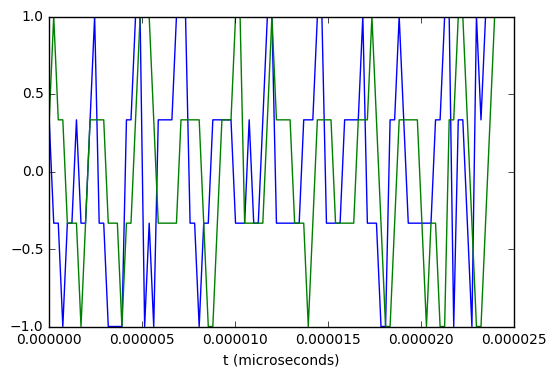

In [4]:
scale = 1/4.092e6
x = np.linspace(0,99,100)
x = x * scale

plt.plot(x, np.real(CData[0:100]))
plt.plot(x, np.imag(CData[0:100]))

#plt.plot(np.real(CData))
#plt.plot(np.imag(CData))

plt.xlabel("t (microseconds)")
#plt.savefig("./plot/meep")
plt.show()

# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.
- The numpy.repeat() function does this exactly

## SVs in this data:

#SV| Doppler(Hz)| Alt (deg)| Az (deg)
---|------------|----------|--------
13 |     3195   | 23.3| 216.5
11 |     3097   |  5.8|  39.0
28 |     1581   | 43.4|  76.3
17 |      359   | 80.6|  80.1
12 |    -2825   |  5.6| 277.7
15 |     1994   | 25.7| 255.4
01 |     1797   | 19.3|  44.4
24 |    -2592   | 31.9| 309.6
30 |     3378   | 13.4| 141.2
06 |    -3321   | 21.1| 159.8

In [5]:
#code = np.repeat(CodeGen.getCode(1023), 4)

#Choose which satellite's C/A code is generated
Satellite = 4000

def getSat(select):
    # Create list of C/A code Taps, for simpler sat selection",
    #sat = [(2,6),(3,7),(4,8),(5,9),(1,9),(2,6),(1,8),(2,9),(3,10),(2,3),(3,4),(5,6),(6,7),(7,8),(8,9),(9,10),(1,4),(2,5),(3,6),(4,7),(5,8),(6,9),(1,3),(4,6),(5,7),(6,8),(7,9),(8,10),(1,6),(2,7),(3,8),(4,9),(5,10),(4,10),(1,7),(2,8),(4,10)]
    sat = [(1,5),(2,6),(3,7),(4,8),(0,8),(1,5),(0,7),(1,8),(2,9),(1,2),(2,3),(4,5),(5,6),(6,7),(7,8),(8,9),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(0,2),(3,5),(4,6),(5,7),(6,8),(7,9),(0,5),(1,6),(2,7),(3,8),(4,9),(3,9),(0,6),(1,7),(3,9)]

    # Create Code Generator object for chosen Satellite
    CodeGen = GoldCode(sat[select - 1]) # Index starts at zero

    # Generate CA Code
    CACode = CodeGen.getCode(1023)

    # Reformat GC to have -1 in place of 0
    for n,i in enumerate(CACode):
        if i==0:
            CACode[n]=-1

    # Repeat each chip 4 times (See markdown in above cell), to match our ADC sample frequency",
    CACodeSampled = np.repeat(CACode,4)
    print("Satellite chosen: %d, with tap: %s" %(select,str(sat[select - 1])))

    # Repeat entire array for each ms of data sampled
    CACodeSampled = np.tile(CACodeSampled,NumberOfMilliseconds)
    print(len(CACodeSampled))
    return CACodeSampled

# Multiply Signal and Code

In [18]:
nfft = TotalSamples

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs#/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)

#fstep = fs/N
fax = np.linspace(0, fs * 2, nfft)

from collections import deque
cadeque = deque()

#for i in CACodeSampled:
#    cadeque.append(i)
    
def mixnplot(CACodeSampled, CData, nfft, fax, lab, plots = False):
    
    mixedData = CData * CACodeSampled
    fftData = np.fft.fft(mixedData, nfft)

    psd = np.abs(fftData) ** 2

    psddb = (10 * np.log10(psd))
    
    #Set plots to True if you want to look over 1023 plots manually
    if plots:
        psddb_norm = psddb - np.max(psddb)
        
        plt.title("Iter: " + str(lab))
        plt.plot(fax/1000, psddb_norm)
        savedir = './plot2/' + str(lab)
        plt.savefig(savedir)
        plt.clf()
    
    
    #Return the ratio of the highest peak
    return psddb.max() - 10*np.log10(psd.mean())

# Get 32 CA codes, mix them, and plot the peak ratios

Satellite chosen: 0, with tap: (3, 9)
4092


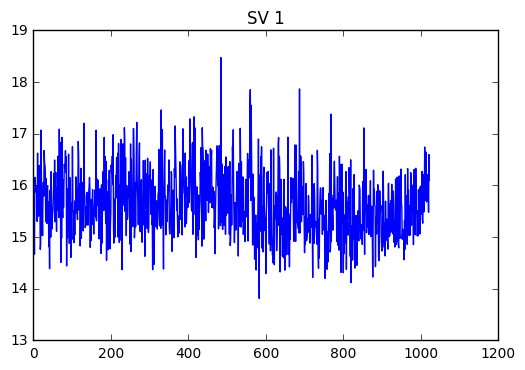

Satellite chosen: 1, with tap: (1, 5)
4092


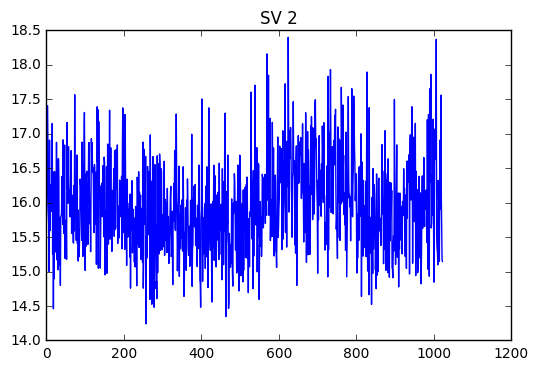

Satellite chosen: 2, with tap: (2, 6)
4092


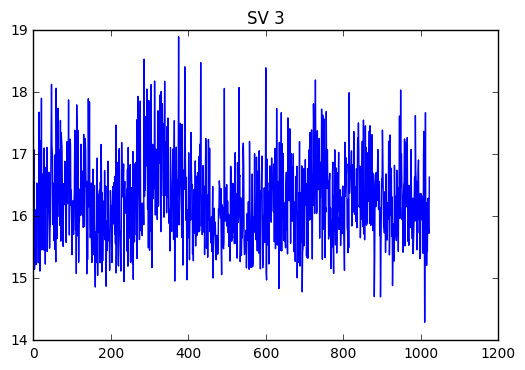

Satellite chosen: 3, with tap: (3, 7)
4092


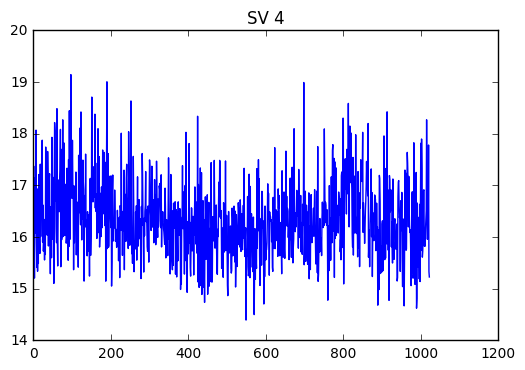

Satellite chosen: 4, with tap: (4, 8)
4092


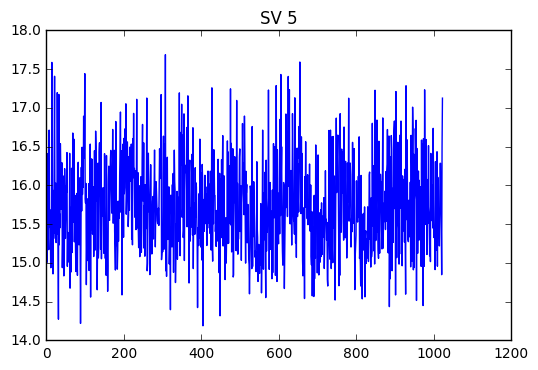

Satellite chosen: 5, with tap: (0, 8)
4092


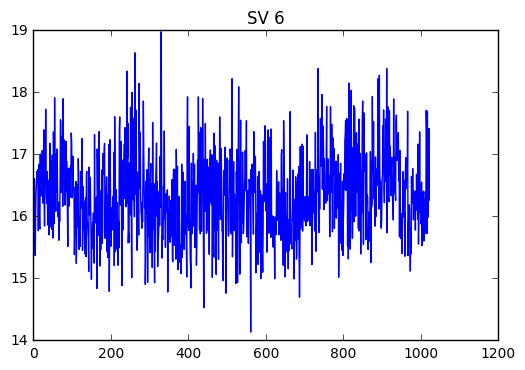

Satellite chosen: 6, with tap: (1, 5)
4092


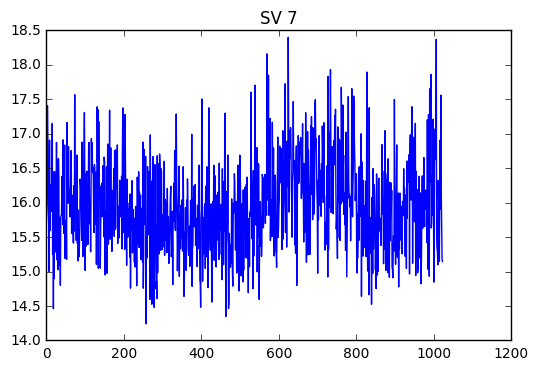

Satellite chosen: 7, with tap: (0, 7)
4092


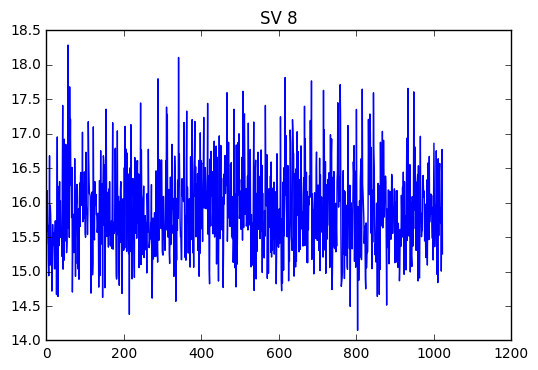

Satellite chosen: 8, with tap: (1, 8)
4092


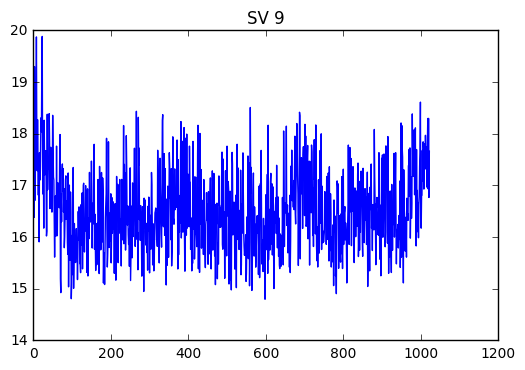

Satellite chosen: 9, with tap: (2, 9)
4092


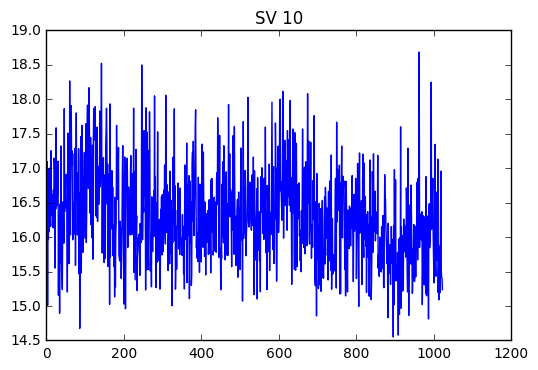

Satellite chosen: 10, with tap: (1, 2)
4092


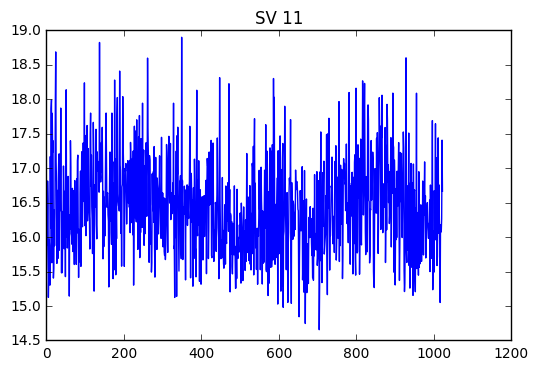

Satellite chosen: 11, with tap: (2, 3)
4092


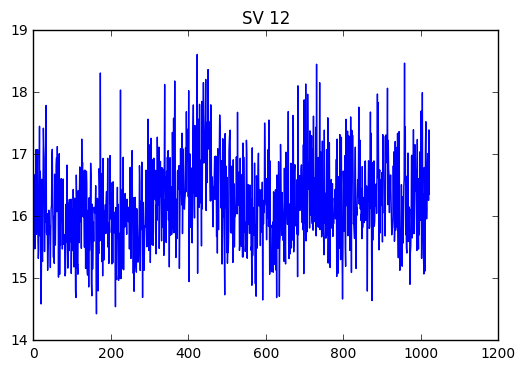

Satellite chosen: 12, with tap: (4, 5)
4092


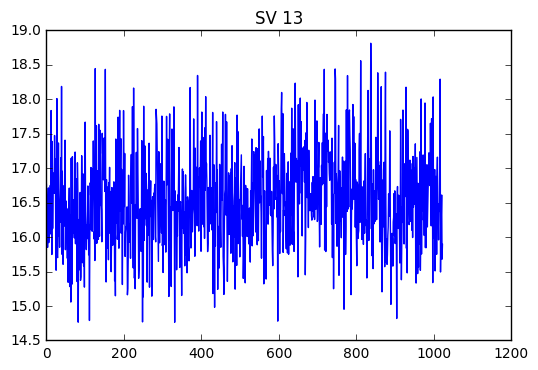

Satellite chosen: 13, with tap: (5, 6)
4092


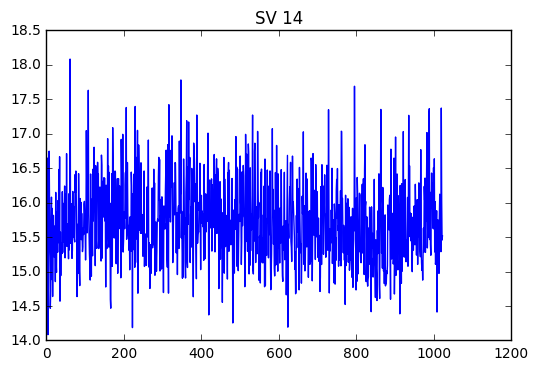

Satellite chosen: 14, with tap: (6, 7)
4092


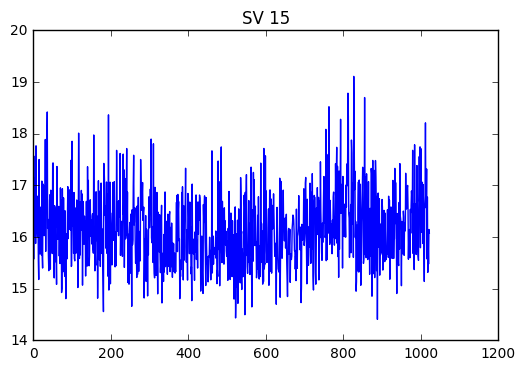

Satellite chosen: 15, with tap: (7, 8)
4092


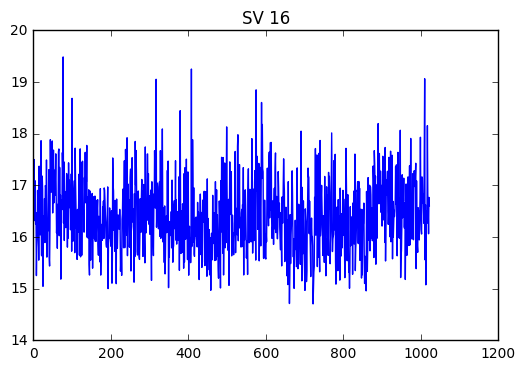

Satellite chosen: 16, with tap: (8, 9)
4092


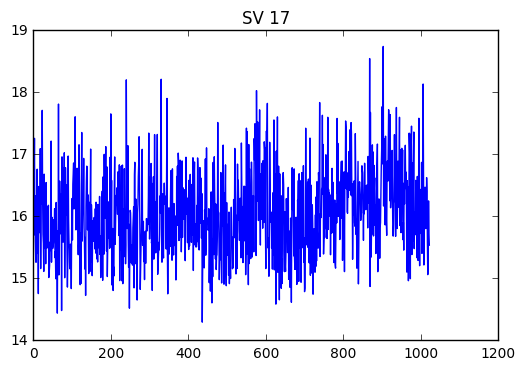

Satellite chosen: 17, with tap: (0, 3)
4092


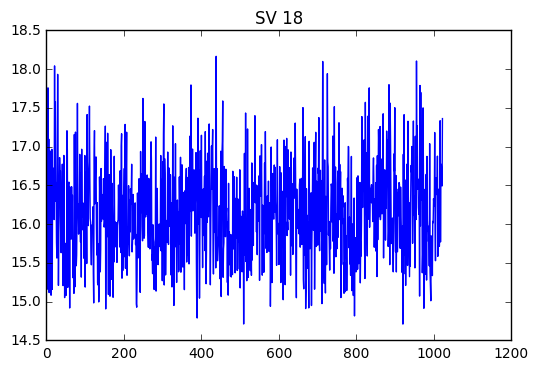

Satellite chosen: 18, with tap: (1, 4)
4092


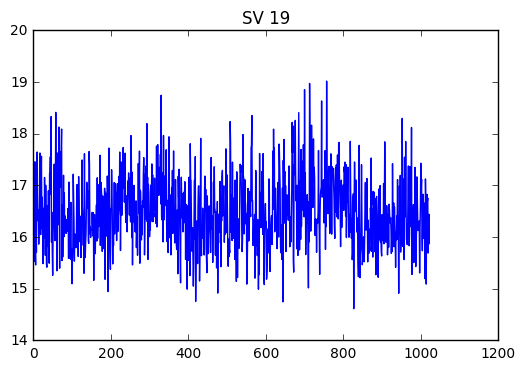

Satellite chosen: 19, with tap: (2, 5)
4092


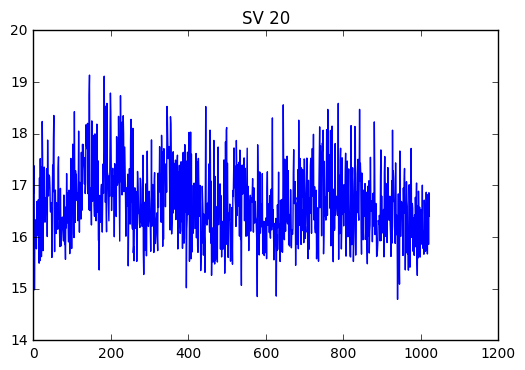

Satellite chosen: 20, with tap: (3, 6)
4092


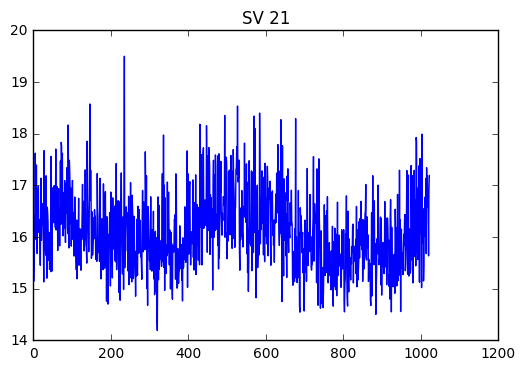

Satellite chosen: 21, with tap: (4, 7)
4092


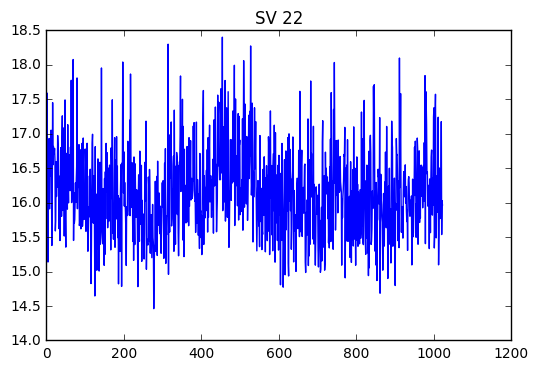

Satellite chosen: 22, with tap: (5, 8)
4092


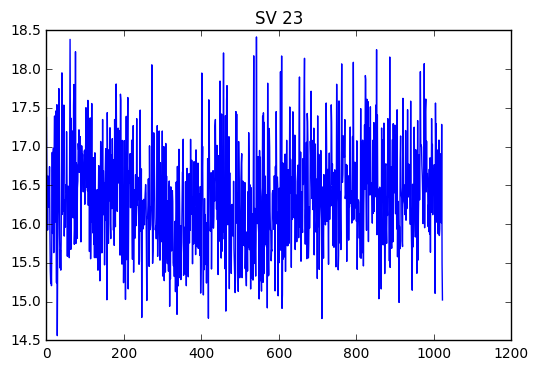

Satellite chosen: 23, with tap: (0, 2)
4092


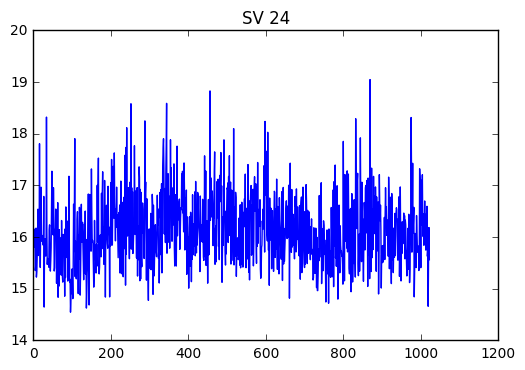

Satellite chosen: 24, with tap: (3, 5)
4092


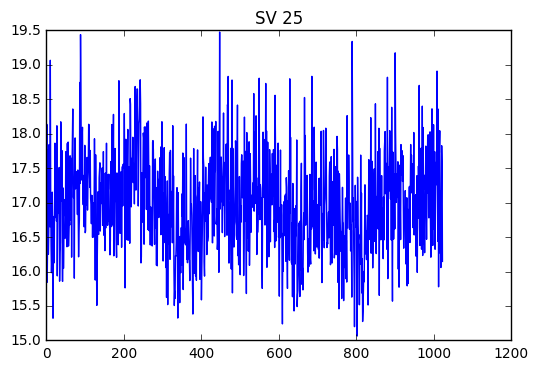

Satellite chosen: 25, with tap: (4, 6)
4092


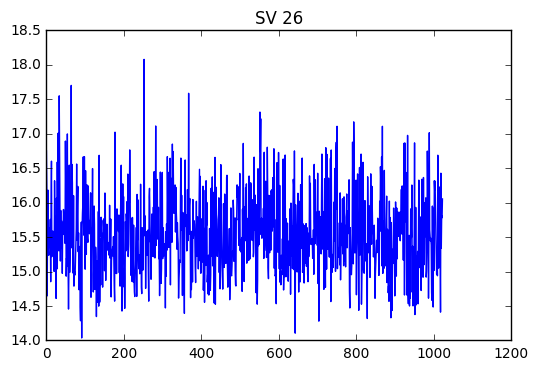

Satellite chosen: 26, with tap: (5, 7)
4092


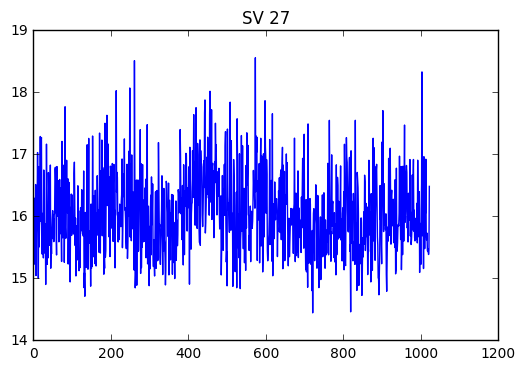

Satellite chosen: 27, with tap: (6, 8)
4092


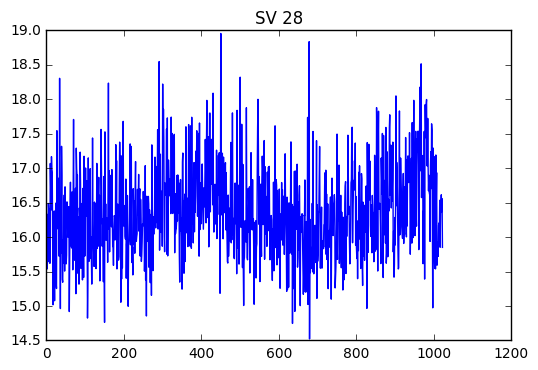

Satellite chosen: 28, with tap: (7, 9)
4092


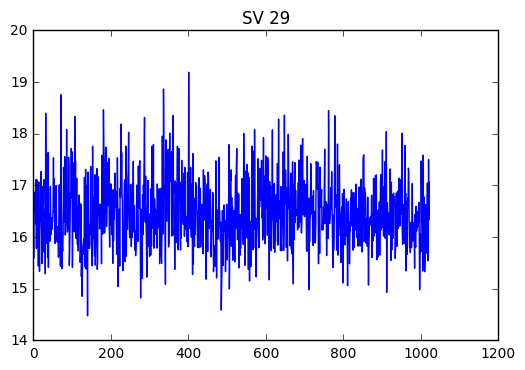

Satellite chosen: 29, with tap: (0, 5)
4092


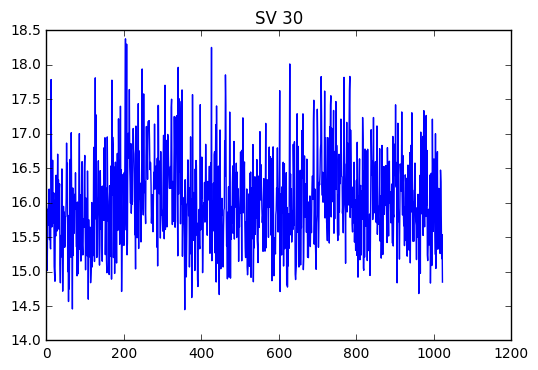

Satellite chosen: 30, with tap: (1, 6)
4092


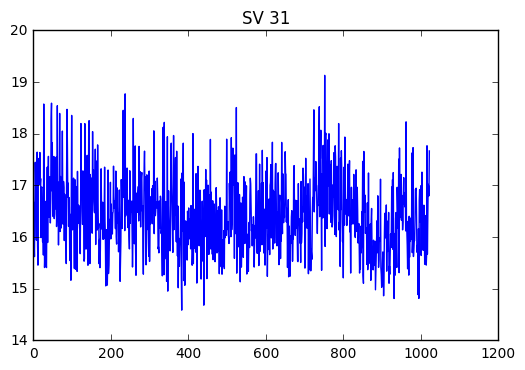

Satellite chosen: 31, with tap: (2, 7)
4092


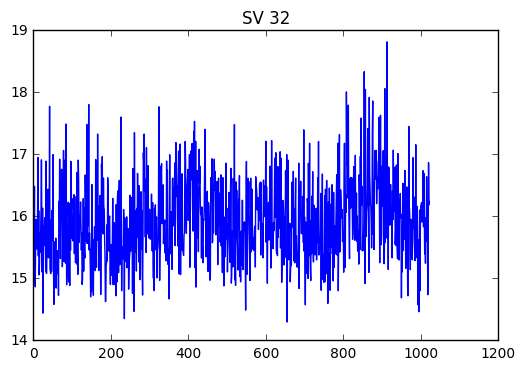

In [21]:
for s in range(32):
    codeq = deque(getSat(s))
    
    ratios = []
    for i in range(1023):
        ratio = mixnplot(codeq, CData, nfft, f, str(i))
        ratios.append(ratio)
        codeq.rotate(-4)
        
        #print(ratio)
        #if i % 10 == 0:
        #   print(str(i*100/1023) + '% complete')
    
    plt.title("SV " + str(s + 1))
    plt.plot(ratios)
    plt.show()
        
    

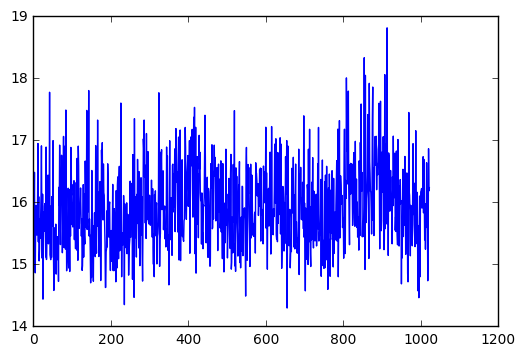

In [8]:
plt.plot(ratios)
plt.show()

# Create output plots for visual comparison

In [22]:
codeq = getSat(1)
codeq = deque(codeq)
for i in range(1023):
    ratio = mixnplot(codeq, CData, nfft, f, str(i), plots=True)
    ratios.append(ratio)
    codeq.rotate(-4)
        
        #print(ratio)
        #if i % 10 == 0:
        #   print(str(i*100/1023) + '% complete')


Satellite chosen: 1, with tap: (1, 5)
4092


In [16]:
codeq

deque([1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
       -1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
       -1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
       -1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       -1,
       1,
       1,
       1,
       1,
       -1,
       -1,
       -1,
   